In [7]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

1.13.0
0.14.0


In [8]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None)

In [9]:
print(train_data.data.shape, test_data.data.shape)
print(train_data[0][0].shape, train_data[0][1])
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
print(class_names)
print(class_to_idx)
print(train_data.targets)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([1, 28, 28]) 9
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
tensor([9, 0, 0,  ..., 3, 0, 5])


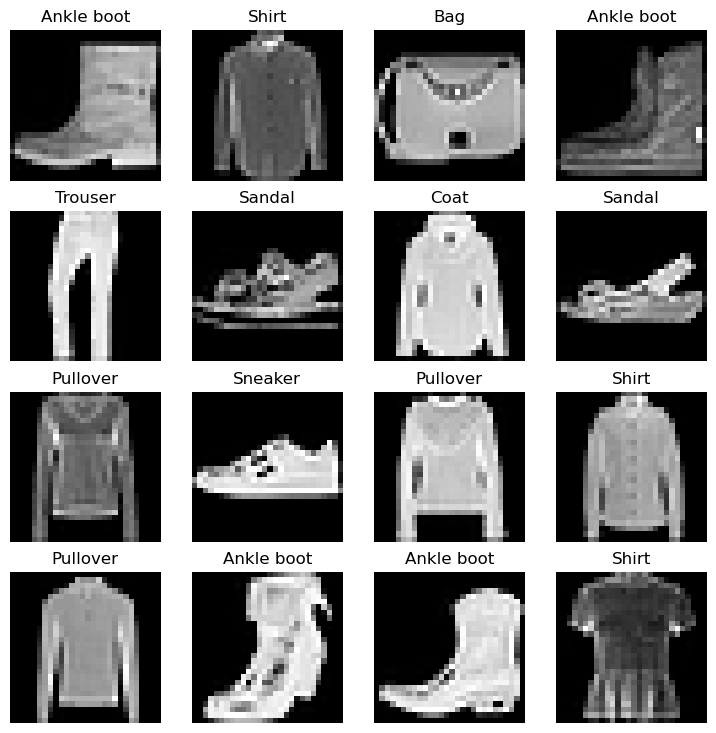

In [10]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size = [1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(dim=0), cmap = "gray")
    plt.title(class_names[label])
    plt.axis(False)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"On device: {device}")
# DataLoader turns our dataset into a Python iterable
# Break nn into minibatches:
#1. More computationally efficient
#2. Gives nn more chances to update gradient per
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              drop_last = True)

print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of size {BATCH_SIZE}")
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)

On device: cuda
Length of train_dataloader: 1875 batches of size 32
Length of test_dataloader: 312 batches of size 32
torch.Size([32, 1, 28, 28]) torch.Size([32])


In [12]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
            )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)


model_0 = FashionMNISTModelV0(input_shape=784,
                            hidden_units=10,
                            output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
print(f'model parameters are on device: {next(model_0.parameters()).device}')
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.1) #weight_decay = 1e-8
model_0

model parameters are on device: cuda:0


FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [14]:
def accuracy_fn(y_true: torch.Tensor,
                y_pred: torch.Tensor):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

# Calculate model 0 results on test dataset
model_0_results = test_step(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

Test loss: 2.33105 | Test accuracy: 16.72%



In [15]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [17]:
torch.manual_seed(42)
import time
from tqdm.auto import tqdm #progress bar

t1 = time.time()
epochs = 10
for epoch in tqdm(range(epochs)):
    train_step(data_loader=train_dataloader, 
        model=model_0, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn)
    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn)

    
print(f"Total time taken {time.time()-t1:.4f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 3.45662 | Train accuracy: 73.82%
Test loss: 3.20779 | Test accuracy: 72.79%

Train loss: 3.88236 | Train accuracy: 74.38%
Test loss: 2.89077 | Test accuracy: 74.54%

Train loss: 3.69161 | Train accuracy: 74.35%
Test loss: 3.32156 | Test accuracy: 76.40%

Train loss: 3.61107 | Train accuracy: 74.23%
Test loss: 5.88486 | Test accuracy: 72.68%

Train loss: 3.94176 | Train accuracy: 74.43%
Test loss: 3.61457 | Test accuracy: 72.81%

Train loss: 3.69213 | Train accuracy: 75.01%
Test loss: 2.73955 | Test accuracy: 77.70%

Train loss: 4.25763 | Train accuracy: 74.30%
Test loss: 4.62498 | Test accuracy: 76.76%

Train loss: 4.02482 | Train accuracy: 74.46%
Test loss: 3.20488 | Test accuracy: 75.74%

Train loss: 3.65984 | Train accuracy: 74.85%
Test loss: 3.13495 | Test accuracy: 76.69%

Train loss: 3.81149 | Train accuracy: 74.36%
Test loss: 5.99207 | Test accuracy: 70.89%

Total time taken 94.6333 seconds


In [ ]:
#TinyVGG [Convolutional layer -> activation layer -> pooling layer]


In [31]:
class FashionMNISTModelTinyVGG(nn.Module):
    """
    Copying TinyVGG
    
    """
    def __init__(self):
        super().__init__()
        colour_channels = 1
        hidden_units = 10
        
        
        block_1 = nn.Sequential(
            nn.Conv2d(in_channels=colour_channels,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        
        block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        
        block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*9,
                      out_features=10))
        
        self.layers = nn.Sequential(block_1, block_2, block_3, classifier)
        
        
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


model = FashionMNISTModelTinyVGG().to(device)

loss_fn = nn.CrossEntropyLoss()

print(f'model parameters are on device: {next(model.parameters()).device}')
# optimizer = torch.optim.Adam(params = model.parameters(),
#                              lr = 0.1) #weight_decay = 1e-8
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.1)
model

model parameters are on device: cuda:0


FashionMNISTModelTinyVGG(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Flatten(st

In [32]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape)
model(train_features_batch.to(device)).shape

torch.Size([32, 1, 28, 28])


torch.Size([32, 10])

In [33]:
test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn)

Test loss: 2.30345 | Test accuracy: 10.01%



In [34]:
torch.manual_seed(3)
import time
from tqdm.auto import tqdm #progress bar

t1 = time.time()
epochs = 10
for epoch in tqdm(range(epochs)):
    train_step(data_loader=train_dataloader, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn)
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn)

    
print(f"Total time taken {time.time()-t1:.4f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.03833 | Train accuracy: 61.09%
Test loss: 0.46394 | Test accuracy: 83.33%

Train loss: 0.42702 | Train accuracy: 84.27%
Test loss: 0.43532 | Test accuracy: 84.02%

Train loss: 0.37869 | Train accuracy: 86.16%
Test loss: 0.37656 | Test accuracy: 86.10%

Train loss: 0.35059 | Train accuracy: 87.02%
Test loss: 0.39189 | Test accuracy: 86.44%

Train loss: 0.33344 | Train accuracy: 87.69%
Test loss: 0.35382 | Test accuracy: 86.98%

Train loss: 0.31982 | Train accuracy: 88.29%
Test loss: 0.33969 | Test accuracy: 88.17%

Train loss: 0.30944 | Train accuracy: 88.47%
Test loss: 0.33773 | Test accuracy: 88.06%

Train loss: 0.30334 | Train accuracy: 88.69%
Test loss: 0.34185 | Test accuracy: 87.55%

Train loss: 0.29527 | Train accuracy: 89.00%
Test loss: 0.33218 | Test accuracy: 87.77%

Train loss: 0.29356 | Train accuracy: 89.08%
Test loss: 0.37845 | Test accuracy: 85.94%

Total time taken 128.9796 seconds


Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

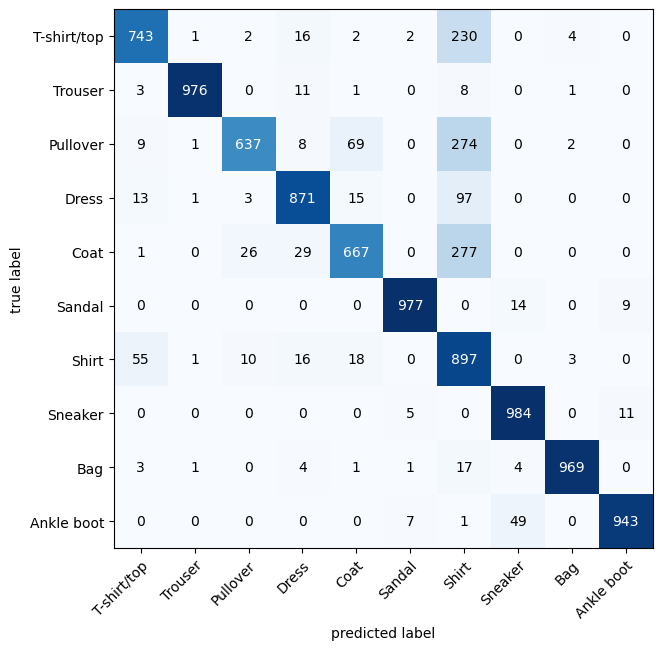

In [30]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              drop_last = False)

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)


from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);